In [1]:
""" Imports of Python Libraries """
import pandas as pd
import numpy as np
import matplotlib as plt
import statsmodels.api as sm

In [2]:
""" Loading Data """
bodyfat_data = pd.read_excel(r"C:\Users\piotr\Desktop\Exam_Multivariate\bodyfat2.XLS")
carmarks_data = pd.read_csv(r"C:\Users\piotr\Desktop\Exam_Multivariate\carmarks.txt", sep = ";")
ozone_data = pd.read_csv(r"C:\Users\piotr\Desktop\Exam_Multivariate\ozone.csv")
primate_data = pd.read_excel(r"C:\Users\piotr\Desktop\Exam_Multivariate\primate.scapulae.xls")

**Excercise 1**

The file bodyfat2.XLS contains measurements of the percentage of bodyfat for 252 men. The Y-variable is the bodyfat percentage. There are 13 explanatory variables (X-variables).

**(a)** Consider the correlations between the 13 explanatory variables. Are there grounds to suspect ill-conditioning?

In [3]:
print(bodyfat_data.head())
print(bodyfat_data.shape)

   density  bodyfat  age  weight  height  neck  chest  abdomen    hip  thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   knee  ankle  biceps  forearm  wrist  
0  37.3   21.9    32.0     27.4   17.1  
1  37.3   23.4    30.5     28.9   18.2  
2  38.9   24.0    28.8     25.2   16.6  
3  37.3   22.8    32.4     29.4   18.2  
4  42.2   24.0    32.2     27.7   17.7  
(252, 15)


In [4]:
x_data = bodyfat_data.drop(columns=["bodyfat", "density"])
y_data = bodyfat_data["bodyfat"]
corr = x_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
age,1,-0.0127461,-0.245212,0.113505,0.17645,0.230409,-0.0503321,-0.200096,0.0175157,-0.105058,-0.0411621,-0.0850556,0.213531
weight,-0.0127461,1,0.486888,0.830716,0.894191,0.887995,0.940884,0.868694,0.853167,0.613685,0.800416,0.630301,0.729775
height,-0.245212,0.486888,1,0.321141,0.226829,0.189766,0.372106,0.338558,0.500501,0.393131,0.318507,0.322027,0.39778
neck,0.113505,0.830716,0.321141,1,0.784835,0.754077,0.734958,0.695697,0.672405,0.477892,0.731146,0.62366,0.744826
chest,0.17645,0.894191,0.226829,0.784835,1,0.915828,0.82942,0.729859,0.719496,0.482988,0.727907,0.580173,0.660162
abdomen,0.230409,0.887995,0.189766,0.754077,0.915828,1,0.874066,0.766624,0.737179,0.453223,0.684983,0.503316,0.619832
hip,-0.0503321,0.940884,0.372106,0.734958,0.82942,0.874066,1,0.89641,0.823473,0.558387,0.739273,0.545014,0.63009
thigh,-0.200096,0.868694,0.338558,0.695697,0.729859,0.766624,0.89641,1,0.79917,0.539797,0.761477,0.566842,0.558685
knee,0.0175157,0.853167,0.500501,0.672405,0.719496,0.737179,0.823473,0.79917,1,0.611608,0.678709,0.555898,0.664507
ankle,-0.105058,0.613685,0.393131,0.477892,0.482988,0.453223,0.558387,0.539797,0.611608,1,0.484855,0.41905,0.566195


In terms of how logically human organisms distribute fat, in case of overweight individuals, this data makes sense. Bodyparts that store most of underskin fat(such as abdomen, thigh or chest), have high corellation with weight and amongst themselves.

**(b)** Perform an OLS regression using all 13 explanatory variables. Which variables are significant?

In [5]:
x_data_with_intercept = sm.add_constant(x_data)
model = sm.OLS(y_data, x_data_with_intercept)
fitted_model = model.fit()
print(fitted_model.summary())

C:\Users\piotr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.50
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           9.71e-64
Time:                        21:23:57   Log-Likelihood:                -718.50
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.3532     22.186     -0.962      0.3

Assuming significance level of **0.05** we will see that OLS would consider following variables significant:

**age, neck, abdomen, forearm, wrist**

This sounds weird that at first we don't have chest or thighs included, but looking at corellation table we can see that they are highly correlated and therefore contain similar information.

**(d)** Use leave-one-out cross-validation for estimating the mean prediction error as a criterion for model selection. Which subset of variables gives the best model, based on this criterion?

Worth commenting on this is the fact that we have in total (2^13 - 1) combinations to calculate if we search through whole superset. This problem is significant when it comes to computational power.

In [6]:
def powerset(seq):
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

feature_powerset = [x for x in powerset(list(x_data.columns))]
feature_powerset.sort()
del feature_powerset[0]            

My first idea of a solution wouldn't converge in sensible time, so I've used some help from one of my colleagues and used his parallelized approach using joblibs parallel. Estimated time would be days in my approach. His is quicker as visible below:

In [7]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from tqdm import tqdm

In [8]:
def test_comb(combination):
    x = x_data.copy()[combination].values
    y = y_data.copy().values
    
    results = []
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(x):
        x_train, y_train = x[train_index], y[train_index]
        x_test, y_test = x[test_index], y[test_index]
        
        model = LinearRegression().fit(x_train, y_train)
        predictions = model.predict(x_test)
        results.append(np.mean((y_test-predictions) ** 2))
        
    return combination, {'mean': np.mean(results), 'std': np.std(results)}

In [9]:
results = Parallel(n_jobs = 4, backend = "loky")(delayed(test_comb)(comb) for comb in tqdm(feature_powerset))

100%|██████████████████████████████████████████████████████████████████████████████| 8191/8191 [21:41<00:00,  6.29it/s]


In [37]:
list(sorted(results, key=lambda x: x[1]['mean'], reverse = False))[:1]

[(['age', 'weight', 'neck', 'abdomen', 'hip', 'thigh', 'forearm', 'wrist'],
  {'mean': 19.166210622898625, 'std': 24.231639556480136})]

Which gives us subset of:
**'age', 'weight', 'neck', 'abdomen', 'hip', 'thigh', 'forearm', 'wrist'**


**Excercise 2**

Consider the data for ozone measurements from thirty two locations in the Los Angeles area, found in the file ozone.csv in the course data directory. Perform a Mantel test to see whether the differences between ozone measurements are smaller for stations that are closer together.

For this excercise we will need Matrixes of measures of Haversine Distances, and differences of Ozone Measurements. Let's first implement those. I do realize this excercise has been solved in R in lecture notes, but I do want to implement it in Python for my self upskilling purposes.

In [38]:
ozone_data.head()

,Station,Av8top,Lat,Lon
0,60,7.225806,34.135833,-117.923611
1,69,5.899194,34.176111,-118.315278
2,72,4.052885,33.823611,-118.187500
3,74,7.181452,34.199444,-118.534722
4,75,6.076613,34.066944,-117.751389


In [108]:
from math import radians, cos, sin, asin, sqrt

def haversine_metric_miles(lat1, lon1, lat2, lon2):
    earth_radius = 3959.87433

    difference_latitude = radians(lat2 - lat1)
    difference_longitude = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(difference_latitude/2)**2 + cos(lat1)*cos(lat2)*sin(difference_longitude/2)**2
    c = 2*asin(sqrt(a))

    return earth_radius * c

def haversine_metric_kilometres(lat1, lon1, lat2, lon2):
    earth_radius = 6372.8

    difference_latitude = radians(lat2 - lat1)
    difference_longitude = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(difference_latitude/2)**2 + cos(lat1)*cos(lat2)*sin(difference_longitude/2)**2
    c = 2*asin(sqrt(a))

    return earth_radius * c

def absolute_distance(measure1,measure2):
    return abs(measure1-measure2)

In [109]:
def create_measure_matrix(data, measure, length_measure):
    n = len(data)
    matrix = np.zeros((n,n))
    if measure == "haversine":
        for i in range(n):
            lat1, lon1 = data.iloc[i][[2]], data.iloc[i][[3]]
            for j in range(n):
                lat2, lon2 = data.iloc[j][[2]], data.iloc[j][[3]]
                if length_measure == "kilometres":
                    matrix[i,j] = haversine_metric_kilometres(lat1, lon1, lat2, lon2)
                elif length_measure == "miles":
                    matrix[i,j] = haversine_metric_miles(lat1, lon1, lat2, lon2)
    elif measure == "absolute":
        for i in range(n):
            measure1 = data.iloc[i][[1]]
            for j in range(n):
                measure2 = data.iloc[j][[1]]
                matrix[i,j] = absolute_distance(measure1, measure2)
    return matrix

In [110]:
haversine_matrix_miles = create_measure_matrix(ozone_data, "haversine", "miles")
absolute_matrix_miles = create_measure_matrix(ozone_data, "absolute", "miles")

Now I will copy-paste implementation of Mantel Test, written down by Jon W. Carr.

In [59]:
# MantelTest v1.2.10
# http://jwcarr.github.io/MantelTest/
#
# Copyright (c) 2014-2016 Jon W. Carr
# Licensed under the terms of the MIT License

import numpy as np
from itertools import permutations
from scipy import spatial, stats

def test(X, Y, perms=10000, method='pearson', tail='two-tail'):
  """
  Takes two distance matrices (either redundant matrices or condensed vectors)
  and performs a Mantel test. The Mantel test is a significance test of the
  correlation between two distance matrices.
  Parameters
  ----------
  X : array_like
      First distance matrix (condensed or redundant).
  Y : array_like
      Second distance matrix (condensed or redundant), where the order of
      elements corresponds to the order of elements in the first matrix.
  perms : int, optional
      The number of permutations to perform (default: 10000). A larger number
      gives more reliable results but takes longer to run. If the actual number
      of possible permutations is smaller, the program will enumerate all
      permutations. Enumeration can be forced by setting this argument to 0.
  method : str, optional
      Type of correlation coefficient to use; either 'pearson' or 'spearman'
      (default: 'pearson').
  tail : str, optional
      Which tail to test in the calculation of the empirical p-value; either
      'upper', 'lower', or 'two-tail' (default: 'two-tail').
  Returns
  -------
  r : float
      Veridical correlation
  p : float
      Empirical p-value
  z : float
      Standard score (z-score)
  """

  # Ensure that X and Y are formatted as Numpy arrays.
  X, Y = np.asarray(X, dtype=float), np.asarray(Y, dtype=float)

  # Check that X and Y are valid distance matrices.
  if spatial.distance.is_valid_dm(X) == False and spatial.distance.is_valid_y(X) == False:
    raise ValueError('X is not a valid condensed or redundant distance matrix')
  if spatial.distance.is_valid_dm(Y) == False and spatial.distance.is_valid_y(Y) == False:
    raise ValueError('Y is not a valid condensed or redundant distance matrix')

  # If X or Y is a redundant distance matrix, reduce it to a condensed distance matrix.
  if len(X.shape) == 2:
    X = spatial.distance.squareform(X, force='tovector', checks=False)
  if len(Y.shape) == 2:
    Y = spatial.distance.squareform(Y, force='tovector', checks=False)

  # Check for size equality.
  if X.shape[0] != Y.shape[0]:
    raise ValueError('X and Y are not of equal size')

  # Check for minimum size.
  if X.shape[0] < 3:
    raise ValueError('X and Y should represent at least 3 objects')

  # If Spearman correlation is requested, convert X and Y to ranks.
  if method == 'spearman':
    X, Y = stats.rankdata(X), stats.rankdata(Y)

  # Check for valid method parameter.
  elif method != 'pearson':
    raise ValueError('The method should be set to "pearson" or "spearman"')

  # Check for valid tail parameter.
  if tail != 'upper' and tail != 'lower' and tail != 'two-tail':
    raise ValueError('The tail should be set to "upper", "lower", or "two-tail"')

  # Calculate the X and Y residuals, which will be used to compute the
  # covariance under each permutation.
  X_residuals, Y_residuals = X - X.mean(), Y - Y.mean()

  # Expand the Y residuals to a redundant matrix.
  Y_residuals_as_matrix = spatial.distance.squareform(Y_residuals, force='tomatrix', checks=False)

  # Get the number of objects.
  m = Y_residuals_as_matrix.shape[0]

  # Calculate the number of possible matrix permutations.
  n = np.math.factorial(m)

  # Initialize an empty array to store temporary permutations of Y_residuals.
  Y_residuals_permuted = np.zeros(Y_residuals.shape[0], dtype=float)

  # If the number of requested permutations is greater than the number of
  # possible permutations (m!) or the perms parameter is set to 0, then run a
  # deterministic Mantel test ...
  if perms >= n or perms == 0:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(n, dtype=float)

    # Enumerate all permutations of row/column orders and iterate over them.
    for i, order in enumerate(permutations(range(m))):

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # ... otherwise run a stochastic Mantel test.
  else:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(perms, dtype=float)

    # Initialize an array to store the permutation order.
    order = np.arange(m)

    # Store the veridical covariance in 0th position...
    covariances[0] = (X_residuals * Y_residuals).sum()

    # ...and then run the random permutations.
    for i in range(1, perms):

      # Choose a random order in which to permute the rows and columns.
      np.random.shuffle(order)

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # Calculate the veridical correlation coefficient from the veridical covariance.
  r = covariances[0] / np.sqrt((X_residuals ** 2).sum() * (Y_residuals ** 2).sum())

  # Calculate the empirical p-value for the upper or lower tail.
  if tail == 'upper':
    p = (covariances >= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'lower':
    p = (covariances <= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'two-tail':
    p = (abs(covariances) >= abs(covariances[0])).sum() / float(covariances.shape[0])

  # Calculate the standard score.
  z = (covariances[0] - covariances.mean()) / covariances.std()

  return r, p, z

In [111]:
test(haversine_matrix_miles, absolute_matrix_miles, tail = "upper")
# Correlation,   P-value, Z value

(0.15899604573504642, 0.031, 2.1749053172798063)

If we would have used 0.05 as a threshold for p-value, then in the given example we would choose H1, that the measurements are closer if stations are closer. 

I do suspect that if we would have used earth radius measure in kilometres, we might have gotten different final result, as measures aren't consistent. Let's check this again:

In [112]:
haversine_matrix_km = create_measure_matrix(ozone_data, "haversine", "kilometres")
absolute_matrix_km = create_measure_matrix(ozone_data, "absolute", "kilometres")

test(haversine_matrix_km, absolute_matrix_km, tail = "upper")
# Correlation,   P-value, Z value

(0.1589960457350464, 0.0318, 2.1600243816344005)

So the results only changed a little bit. I guess it isn't that suspicious, granted that the numbers we multiplied by either miles or kilometres, weren't that big. Results are coherent with those in lecture notes.

**Excercise 3**

Consider the ‘car marks’ data set in carmarks.txt in the course data directory. The data are averaged marks for 24 cars from a sample of 40 persons. The marks range from 1 (very good) to 6 (very bad). The first two columns contain ‘type’ and ‘model’. The next 8 columns contain the variables: economy, service, non-depreciation of value, price (1 is cheapest), design, sporty car, safety, easy handling. Let the X variables be (price, value stability) and let the Y variables be (economy, service, design, sporty car, safety, easy handling). Perform a canonical correlation analysis on the data and draw suitable conclusions.

In [69]:
from sklearn.cross_decomposition import CCA

In [62]:
carmarks_data.head()

,CARMARK,ECONOMY,SERVICE,VALUE,PRICE,DESIGN,SPORT,SAFETY,EASYINESS
0,A100,3.9,2.8,2.2,4.2,3.0,3.1,2.4,2.8
1,BMW3,4.8,1.6,1.9,5.0,2.0,2.5,1.6,2.8
2,CiAX,3.0,3.8,3.8,2.7,4.0,4.4,4.0,2.6
3,Ferr,5.3,2.9,2.2,5.9,1.7,1.1,3.3,4.3
4,FiUn,2.1,3.9,4.0,2.6,4.5,4.4,4.4,2.2


In [68]:
x_carmarks = carmarks_data[["PRICE","VALUE"]]
y_carmarks = carmarks_data.drop(["CARMARK", "PRICE", "VALUE"], axis=1)

As in our case min(p,q) = 2, where p and q denote vectors for which we want to compute analysis, we want only 2 components:

In [71]:
cca = CCA(n_components=2, scale=True)
X_c, Y_c = cca.fit_transform(x_carmarks, y_carmarks)

In [79]:
print(cca.x_loadings_)
print("\n",cca.y_loadings_)

[[-0.70997646  0.8481482 ]
 [ 0.73558319  0.52975903]]

 [[-0.4210311   0.58835394]
 [ 0.63409698  0.28599174]
 [ 0.63172266 -0.1585578 ]
 [ 0.61034664 -0.14859005]
 [ 0.62245444  0.30774151]
 [ 0.00529752  0.80116521]]


In [81]:
print(cca.x_loadings_[:,0])

[-0.70997646  0.73558319]


So now as we have all the canonical weights, let's look up them more closely, and analyze them as per lectures:
Let's remind us first, which number resembles which feature:

In [101]:
print(" PRICE,       VALUE")
print(cca.x_loadings_[:,0])
print("\n ECONOMY,     SERVICE,    DESIGN,     SPORT,      SAFETY,     EASYINESS")
print(cca.y_loadings_[:,0])

 PRICE,       VALUE
[-0.70997646  0.73558319]

 ECONOMY,     SERVICE,    DESIGN,     SPORT,      SAFETY,     EASYINESS
[-0.4210311   0.63409698  0.63172266  0.61034664  0.62245444  0.00529752]


First we need to remind ourselves, that due to the ranking of prices, very low PRICE value resembles that the car is actually expensive.

In this case we can see that high **PRICE**, with high stability in **VALUE** is correlated with everything besides **EASYINESS** of handling the car. Worth noting that those cars are usually highly not **ECONOMICAL**. Which makes perfect logical sense.

In [113]:
print(" PRICE,       VALUE")
print(cca.x_loadings_[:,1])
print("\n ECONOMY,     SERVICE,    DESIGN,     SPORT,      SAFETY,     EASYINESS")
print(cca.y_loadings_[:,1])

 PRICE,       VALUE
[0.8481482  0.52975903]

 ECONOMY,     SERVICE,    DESIGN,     SPORT,      SAFETY,     EASYINESS
[ 0.58835394  0.28599174 -0.1585578  -0.14859005  0.30774151  0.80116521]


In this case we can see that **DESIGN** and **SPORT** are not that correlated with **PRICE** and **VALUE** while, **SAFETY** and **SERVICE** are only moderately correlated, contrary to highly correlated **EASYINESS** and **ECONOMY**.



**Excercise 4**

The data in primate.scapulae.txt (and primate.scapulae.xls) contain indices and angles that are related to scapular shape (shoulder bones of primates), but not to functional meaning. There are 8 variables in the data set. The first five (AD.BD, AD.CD, EA.CD, Dx.CD, SH.ACR) are indices and the last three (EAD, β, γ) are angles. Of the 105 measurements on each variable, 16 were taken on Hylobates scapulae, 15 on Pongo scapulae, 20 on Pan scapulae. 14 on Gorilla scapulae, and 40 on Homo scapulae. The angle γ was not available for Homo.

**(a)** Apply agglomerative and divisive hierarchical methods for clustering the variables using all 5 indices and the 2 angles available for all items. Construct dendrograms with single-linkage, average-linkage, complete-linkage and Ward-linkage for the methods. When an isolated observation appears high enough up in the dendrogram, it becomes a cluster of size one and hence plays the role of an outlier. Which linkage methods give outliers?

In [38]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
import seaborn as sn
import random

In [114]:
primate_data.head()

,genus,AD.BD,AD.CD,EA.CD,Dx.CD,SH.ACR,EAD,beta,gamma,class,classdigit
0,54,65.56,166.0,50.55,12.80,70.3,115,14,45.0,Hylobates,1
1,54,50.91,93.9,61.82,13.09,75.0,121,20,54.0,Hylobates,1
2,54,46.15,80.8,64.10,11.80,70.0,120,25,61.0,Hylobates,1
3,54,70.29,220.5,50.00,12.75,61.1,113,12,45.0,Hylobates,1
4,54,63.16,144.0,57.89,12.98,64.9,115,14,46.0,Hylobates,1


In [40]:
clustering_data = primate_data.drop(["gamma", "class", "classdigit"], axis = 1)
scaler = MinMaxScaler()
scaled_cluster_data = scaler.fit_transform(clustering_data)

C:\Users\piotr\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


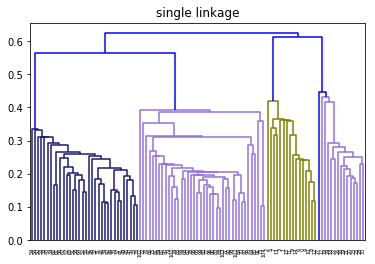

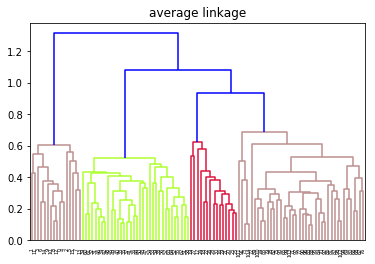

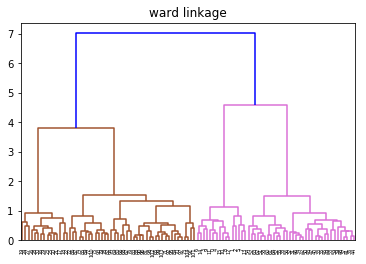

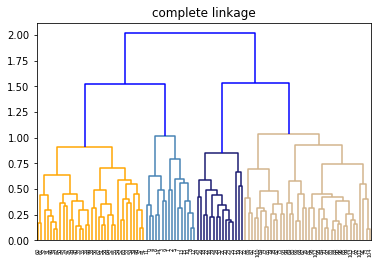

In [41]:
color_list = ["red", "sienna", "greenyellow", "mediumpurple", "midnightblue", "steelblue", "saddlebrown", "maroon", "peachpuff","crimson", "dimgray", "lightcoral","orange", "tan", "palegreen", "olive", "orchid", "rosybrown", "b","thistle"]

for method in ["single","average", "ward", "complete"]:
    Z = linkage(scaled_cluster_data, method = method) 
    plt.figure()
    plt.title(f"{method} linkage" )
    set_link_color_palette([random.choice(color_list) for i in range(5)])
    dendro = dendrogram(Z)
    plt.show()

Although amount of observations makes this being readable harder, we cann see that in case of single linkage we get outlier!

**(b)** Find the five-cluster solutions for these methods. Construct confusion tables and compute the misclassification rate. Which method gives the lowest rate? Which gives the highest rate?

This solution won't be pretty as class labels are assigned in heuristic way, so I will have to map them to get confusion matrices, and missclasification rates.

In [42]:
dictionary_of_labels = {}

for method in ["single","average", "ward", "complete"]:
    cluster_model = AgglomerativeClustering(n_clusters = 5, linkage = method)
    fitted_cluster_model = cluster_model.fit(scaled_cluster_data)
    dictionary_of_labels[f"{method} labels"] = fitted_cluster_model.labels_ +1
    
correct_labels = np.array(primate_data["classdigit"])

In [43]:
primate_data.groupby(["class", "classdigit"]).size().reset_index()

,class,classdigit,0
0,Gorilla,4,14
1,Homo,5,40
2,Hylobates,1,16
3,Pan,3,20
4,Pongo,2,15


In [44]:
correct_labels_map = {4:"gorilla",5:"homo",1:"hylobates",3:'pan',2:"pongo"}
correct_labels = np.array(pd.Series(correct_labels).map(correct_labels_map))
correct_labels

array(['hylobates', 'hylobates', 'hylobates', 'hylobates', 'hylobates',
       'hylobates', 'hylobates', 'hylobates', 'hylobates', 'hylobates',
       'hylobates', 'hylobates', 'hylobates', 'hylobates', 'hylobates',
       'hylobates', 'pongo', 'pongo', 'pongo', 'pongo', 'pongo', 'pongo',
       'pongo', 'pongo', 'pongo', 'pongo', 'pongo', 'pongo', 'pongo',
       'pongo', 'pongo', 'pan', 'pan', 'pan', 'pan', 'pan', 'pan', 'pan',
       'pan', 'pan', 'pan', 'pan', 'pan', 'pan', 'pan', 'pan', 'pan',
       'pan', 'pan', 'pan', 'pan', 'gorilla', 'gorilla', 'gorilla',
       'gorilla', 'gorilla', 'gorilla', 'gorilla', 'gorilla', 'gorilla',
       'gorilla', 'gorilla', 'gorilla', 'gorilla', 'gorilla', 'homo',
       'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo',
       'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo',
       'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo',
       'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo', 'homo',
 

In [45]:
single_labels = dictionary_of_labels["single labels"]
single_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [46]:
single_labels_map = {5:"gorilla",2:"homo",3:"hylobates",4:'pan',1:"pongo"}
single_labels = np.array(pd.Series(single_labels).map(single_labels_map))

In [47]:
average_labels = dictionary_of_labels["average labels"]
average_labels

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5], dtype=int64)

In [48]:
average_labels_map = {5:"gorilla",2:"homo",4:"hylobates",3:'pan',1:"pongo"}
average_labels = np.array(pd.Series(average_labels).map(average_labels_map))

In [49]:
ward_labels = dictionary_of_labels["ward labels"]
ward_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 5, 2, 5, 5, 2, 5, 5, 5, 2, 2, 5, 2, 2, 5, 5, 5,
       2, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2], dtype=int64)

In [50]:
ward_labels_map = {5:"gorilla",2:"homo",3:"hylobates",1:'pan',4:"pongo"}
ward_labels = np.array(pd.Series(ward_labels).map(ward_labels_map))

In [51]:
complete_labels = dictionary_of_labels["complete labels"]
complete_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       2, 2, 2, 2, 2, 2, 5, 2, 5, 5, 2, 5, 5, 5, 2, 2, 5, 2, 2, 5, 5, 5,
       2, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2], dtype=int64)

In [52]:
complete_labels_map = {5:"gorilla",2:"homo",1:"hylobates",4:'pan',3:"pongo"}
complete_labels = np.array(pd.Series(complete_labels).map(complete_labels_map))

single linkage measures: 
 Misclassification rate = 0.1428571428571429


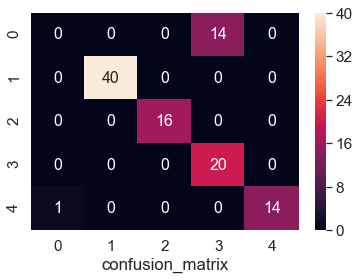

average linkage measures: 
 Misclassification rate = 0.17142857142857137


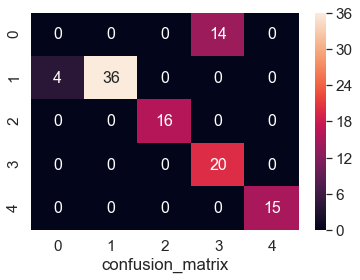

complete linkage measures: 
 Misclassification rate = 0.2571428571428571


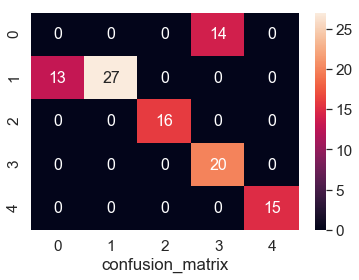

ward linkage measures: 
 Misclassification rate = 0.2571428571428571


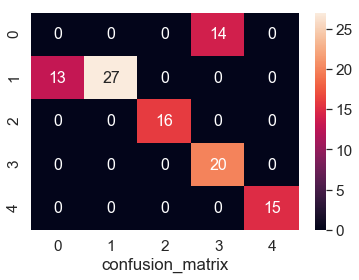

In [56]:
method_dict = {"single": single_labels, "average": average_labels, "complete": complete_labels, "ward": ward_labels}

for method_name, labels in method_dict.items():
    print(f"{method_name} linkage measures: \n Misclassification rate = {1-np.mean(labels==correct_labels)}")
    array = confusion_matrix(correct_labels, labels)
    df_cm = pd.DataFrame(array, range(5), range(5))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel('confusion_matrix')
    plt.show()

Unfortunately above solution isn't as pretty as previous one, but I couldn't find a way to optimize(in non-manual way) changing label indices.

Interestingly gorillas were never predicted right. But as we can see, single linkage performed the best, with both ward and complete performing EXACTLY the same(the worst). Worth noting is that all cluster labels achieved via different clustering techniques, aren't representing the same class names, as in case of "classdigit" in original dataframe. Those label conversions seen above are just my interpretations of what class would given label describe.

**Excercise 5**

Consider again the data in the file primate.scapulae.txt in the course data directory; now the object is to carry out discriminant function analysis. Carry out five linear discriminant analyses (one for each primate species), where each analysis is of the form ‘one class versus the rest’. Find the spatial zone (known as the ambiguous region) that does not correspond to any LDA assignment of a class of primate (out of the five considered).

Suppose that LDA boundaries are found for the primate.scapulae data by carrying out a sequence of $$
\left(\begin{array}{l}{5} \\ {2}\end{array}\right)=10
$$ LDA problems, each involving a distinct pair of primate species. Find the ambigous region that does not correspond to any LDA assignment of a class of primate (out of the five considered). Suppose we classify each primate in the data set by taking a vote based upon these boundaries. Estimate the resulting misclassification rate and compare it with the rate from the multi-class classification procedure.

**Solution starts here**

This task isn't easy, as plotting decision boundaries for singular LDA without implementing them myself is very difficult. Then making them overlap, and indicating which space belongs to which class after prediction, is even worse. This task exceeds my knowledge and skills to use either matplotlib or ggplot to solve it.

Below solution uses in-built python LDA function, which when I've read through documentation I couldn't understand if it is either OvA or OvO algorithm. So additionally I've added OvR classifier from scikit learn.

In [3]:
primate_data.head()

,genus,AD.BD,AD.CD,EA.CD,Dx.CD,SH.ACR,EAD,beta,gamma,class,classdigit
0,54,65.56,166.0,50.55,12.80,70.3,115,14,45.0,Hylobates,1
1,54,50.91,93.9,61.82,13.09,75.0,121,20,54.0,Hylobates,1
2,54,46.15,80.8,64.10,11.80,70.0,120,25,61.0,Hylobates,1
3,54,70.29,220.5,50.00,12.75,61.1,113,12,45.0,Hylobates,1
4,54,63.16,144.0,57.89,12.98,64.9,115,14,46.0,Hylobates,1


In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

In [29]:
x_primate = primate_data.drop(["genus","classdigit", "class", "gamma"], axis = 1)
y_primate = primate_data["classdigit"]

In [36]:
OvR_classifier = OneVsRestClassifier(LinearDiscriminantAnalysis(), n_jobs = -1).fit(x_primate,y_primate)
predicted_OvR_classes = OvR_classifier.predict(x_primate)

print(f"Misclassification rate = {1-np.mean(predicted_OvR_classes==y_primate)}")

Misclassification rate = 0.04761904761904767


I understand that LDA should decrease dimensionality of my data, and therefore allow me to plot the 2D version. But above scikit class doesn't have fit_transform method, so I can't get the value in a transformed space.

All I can tell is that the misclassification happens, and surely there are some classes overlapping. I can analyze it further by checking confusion matrix:

In [37]:
from sklearn.metrics import confusion_matrix
print(f"Confusion matrix: \n {confusion_matrix(y_primate, predicted_OvR_classes)}")

Confusion matrix: 
 [[16  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  5  9  0]
 [ 0  0  0  0 40]]


So there are some misclassifications between 3rd and 4th class. Let's use some of Python's API to plot how it could have happened:

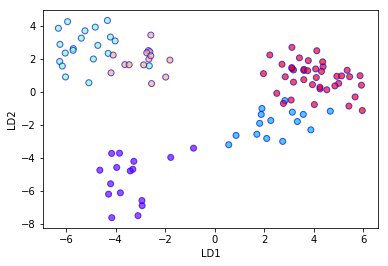

In [31]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(x_primate, y_primate)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_primate,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

So in this case even without the decision boundaries, I would expect the center of this plot to be ambigous region. This region would be a point in the set where our algorithm wouldn't be sure which class it would choose.

So in general in OvR as we only have 5 decision boundaries, we would have bigger ambigous region, as we have a space sliced into quite chunky polygons.

In case of OvO those polygons would be a lot smaller, so those ambigous regions would be in few smaller regions. I will try and illustrate it, but we need to take those plots with a grain of salt, as I've made them manually, and are only used to show intuition.

**OvR**:

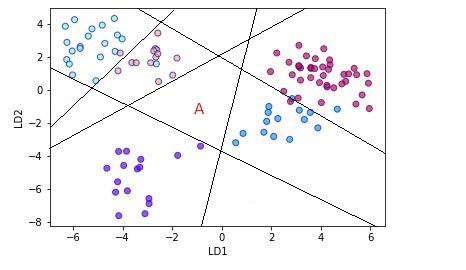

**OvO**:

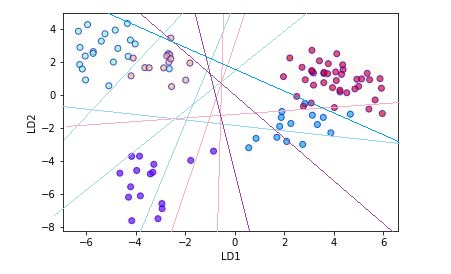

These two plots aren't really readable, but what should be taken away, that ambigous region for OvO, should be way smaller if we look at the sub-polygons in the above space. I would expect one of those in the center to be the ambigous region.

While in case of OvR above, I'd expect polygon marked with red A to be ambigous region.

But as I mentioned. Those should be taken with a grain of salt as those plots of the classes in 2d space, aren't really representative of OvO and OvR solutions, and are just their approximations.